# GPcounts on bulk dataset

Nuha BinTayyash, 2020

This notebook shows how to run [DESeq2](https://bioconductor.org/packages/release/bioc/html/DESeq2.html) R package to normalize [fission yeast](https://bioconductor.org/packages/release/data/experiment/html/fission.html) gene expression data. Then, compare GPcounts with negative binomial likelihood and Gaussian likelihood to find differentially expressed genes in one sample test and two-sample tests.

### load [fission dataset](https://bioconductor.org/packages/3.11/data/experiment/html/fission.html) and normalize it using DESeq2

In [ ]:
library("fission")
data("fission")
counts <- SummarizedExperiment::assay(fission)
keep <- rowMeans(counts) >1
counts <- counts[keep,]
col_data <- fission@colData
write.csv(counts, file = "fission_counts.csv")
write.csv(col_data, file = "fission_col_data.csv")

wt_counts <- counts[,1:18]
wt_col_data <- col_data[1:18,]
write.csv(wt_counts, file = "wt_counts.csv")
write.csv(wt_col_data, file = "wt_col_data.csv")
dim(counts)

DESeq2 two samples test

In [ ]:
col_data_scaled <- read.csv(file = 'fission_col_data_scaled.csv',row.names = 1, header = TRUE)

library("DESeq2")
dds <- DESeqDataSetFromMatrix(countData = counts,
                              colData = col_data_scaled,
                              design = ~ strain + minute + strain:minute)

dds <- estimateSizeFactors(dds)
normalized_counts<-counts(dds, normalized=TRUE)
dim(normalized_counts)
write.csv(normalized_counts, file = "fission_normalized_counts_scaled.csv")

dds <- DESeq(dds, test="LRT", reduced = ~ strain + minute)
res <- results(dds)
write.csv(as.data.frame(res),file="fission_DESeq2_tst_scaled.csv")

In [ ]:
col_data_scaled <- read.csv(file = 'wt_col_data_scaled.csv',row.names = 1, header = TRUE)

dds <- DESeqDataSetFromMatrix(countData = wt_counts,
                              colData = wt_col_data,
                              design = ~  minute)

dds <- estimateSizeFactors(dds)
normalized_counts<-counts(dds, normalized=TRUE)
write.csv(normalized_counts, file = "wt_normalized_counts_scaled.csv")

dds <- DESeq(dds, test="LRT", reduced = ~ 1)
res <- results(dds)
write.csv(as.data.frame(res),file="fission_DESeq2_ost_scaled.csv")

#### Change R kernel to Python kernel

In [1]:
import numpy as np
import pandas as pd
import gpflow

In [2]:
filename = 'fission_normalized_counts_scaled.csv'
#filename = 'wt_normalized_counts_scaled52.csv'
Y = pd.read_csv(filename,index_col=[0])
X = pd.read_csv('fission_col_data_scaled.csv',index_col=[0])
X = X[['minute']]
#X.iloc[0:18,:]

Fit some fission gene normalized data using GPcounts -- Two samples test

In [3]:
from matplotlib import pyplot as plt
import statsmodels.api as sm

def plot():
    plt.tick_params(labelsize='large', width=2)     
    #plt.ylabel('Gene Expression', fontsize=16)
    #plt.xlabel('Times', fontsize=16)
    c = 'royalblue'
    
    if model_index == 3:
        c = 'green'
    
    plt.plot(xtest, mean,color= c, lw=2) 
    
    if likelihood == 'Gaussian':
        plt.fill_between(xtest[:,0],
                            mean[:,0] - 1*np.sqrt(var[:,0]),
                            mean[:,0] + 1*np.sqrt(var[:,0]),color=c,alpha=0.2) # one standard deviation
        plt.fill_between(xtest[:,0],
                            mean[:,0] - 2*np.sqrt(var[:,0]),
                            mean[:,0] + 2*np.sqrt(var[:,0]),color=c, alpha=0.1)# two standard deviation
    else:
       
        lowess = sm.nonparametric.lowess    
        # one standard deviation 68%
        percentile_16 = lowess(np.percentile(var, 16, axis=0),xtest[:,0],frac=1./5, return_sorted=False)
        percentile_16 = [(i > 0) * i for i in percentile_16]
        percentile_84 = lowess(np.percentile(var, 84, axis=0),xtest[:,0],frac=1./5, return_sorted=False)
        percentile_84 = [(i > 0) * i for i in percentile_84]
        plt.fill_between(xtest[:,0],percentile_16,percentile_84,color=c,alpha=0.2)
        
        # two standard deviation 95%
        percentile_5 = lowess(np.percentile(var, 5, axis=0),xtest[:,0],frac=1./5, return_sorted=False)
        percentile_5 = [(i > 0) * i for i in percentile_5]
        percentile_95 = lowess(np.percentile(var,95, axis=0),xtest[:,0],frac=1./5, return_sorted=False)
        percentile_95 = [(i > 0) * i for i in percentile_95]
        plt.fill_between(xtest[:,0],percentile_5,percentile_95,color=c,alpha=0.1)
    
    if test == 'Two_samples_test' and model_index == 1:
        plt.scatter(model.data[0][0:int(model.data[0].shape[0]/2)],model.data[1][0:int(model.data[0].shape[0]/2)], s=30, marker='o', color= 'royalblue',alpha=1.) #data    
        plt.scatter(model.data[0][int(model.data[0].shape[0]/2)::],model.data[1][int(model.data[0].shape[0]/2)::], s=30, marker='o', color= 'green',alpha=1.) #data

    else: 
        plt.scatter(model.data[0],model.data[1],s=30,marker = 'o',color=c,alpha=1.)
    
    
    if not(test == 'Two_samples_test' and model_index == 2):
        plt.show()
    

In [4]:
from GPcounts.GPcounts_Module import Fit_GPcounts
likelihood = 'Negative_binomial' 
genes_name = ['SPNCRNA.750','SPBTRNAARG.07','SPNCRNA.735','SPBPB2B2.06c','SPAC869.06c','SPCC1281.04','SPBC1711.14','SPAC11D3.01c']
gp_counts = Fit_GPcounts(X,Y.loc[genes_name])
log_likelihood_ratio = gp_counts.Two_samples_test(likelihood)
log_likelihood_ratio

100%|██████████| 8/8 [00:43<00:00,  5.48s/it]


,Shared_log_likelihood,model_1_log_likelihood,model_2_log_likelihood,log_likelihood_ratio
SPNCRNA.750,-74.152538,-42.218700,-31.763184,0.170654
SPBTRNAARG.07,-219.672160,-105.339884,-113.982153,0.350123
SPNCRNA.735,-132.432729,-66.956764,-63.702851,1.773114
SPBPB2B2.06c,-119.192684,-60.485343,-57.312292,1.395050
SPAC869.06c,-109.093531,-58.660935,-48.272986,2.159610
SPCC1281.04,-146.119576,-77.166138,-65.486253,3.467185
SPBC1711.14,-82.881674,-43.453921,-37.440495,1.987259
SPAC11D3.01c,-229.365282,-119.660087,-103.830151,5.875044


100%|██████████| 8/8 [00:27<00:00,  3.43s/it]


SPNCRNA.750


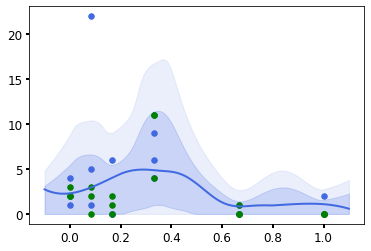

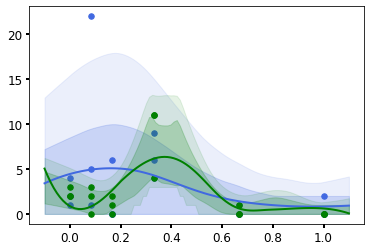

SPBTRNAARG.07


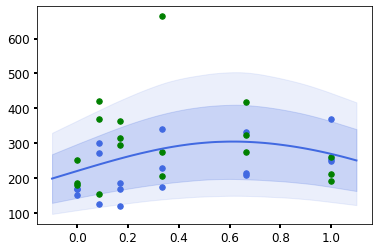

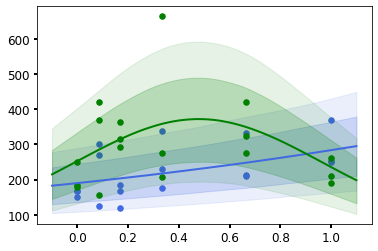

SPNCRNA.735


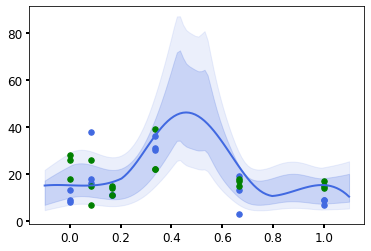

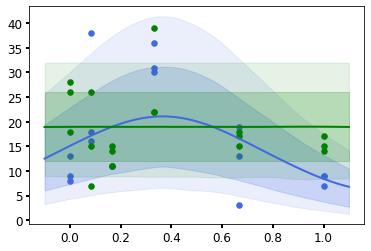

SPBPB2B2.06c


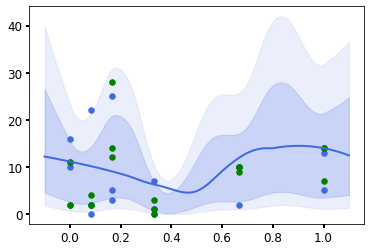

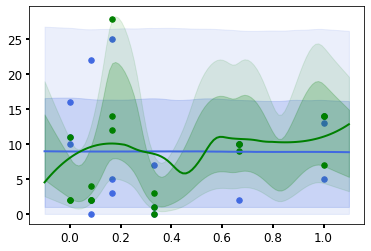

SPAC869.06c


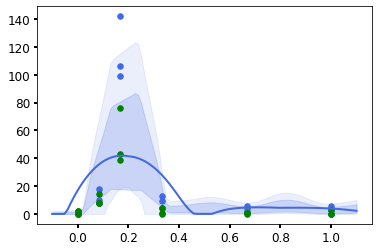

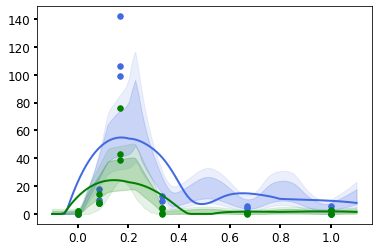

SPCC1281.04


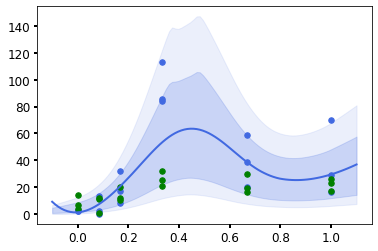

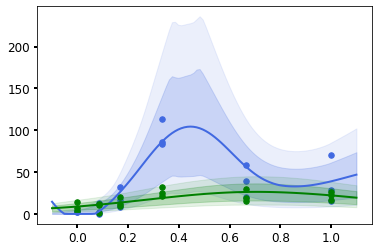

SPBC1711.14


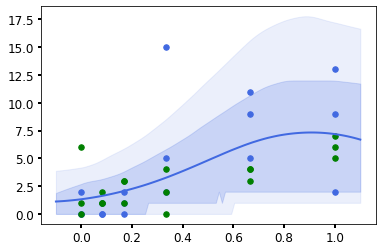

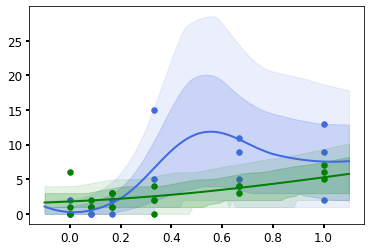

SPAC11D3.01c


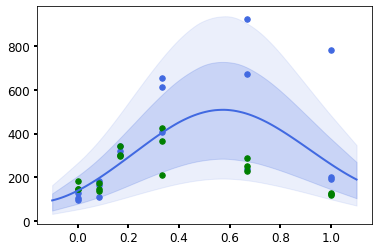

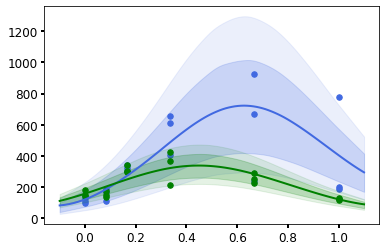

In [5]:
indexes = log_likelihood_ratio.index.values # list of genes to be plotted 
test = 'Two_samples_test' # name of the test
xtest = np.linspace(np.min(X.values)-.1,np.max(X.values)+.1,100)[:,None] # points to make prediction
likelihood = 'Negative_binomial'
params = gp_counts.load_models(indexes,test,xtest,likelihood)

for i in range(len(indexes)):
    fig = plt.figure()
    print(indexes[i])
    model_index = 1
    for mean,var,model in zip(params['means'][i],params['vars'][i],params['models'][i]):
        plot() 
        model_index = model_index + 1

In [6]:
likelihood = 'Gaussian'
log_likelihood_ratio = gp_counts.Two_samples_test(likelihood)
log_likelihood_ratio

100%|██████████| 8/8 [00:16<00:00,  2.02s/it]


,Shared_log_likelihood,model_1_log_likelihood,model_2_log_likelihood,log_likelihood_ratio
SPNCRNA.750,-42.200478,-25.441840,-18.933791,-2.175153
SPBTRNAARG.07,-20.635520,-8.526115,-12.283096,-0.173691
SPNCRNA.735,-29.819021,-21.763828,-15.829874,-7.774680
SPBPB2B2.06c,-51.239404,-27.530745,-24.331187,-0.622528
SPAC869.06c,-48.531642,-24.645012,-24.603391,-0.716760
SPCC1281.04,-47.501467,-27.585391,-19.397972,0.518104
SPBC1711.14,-37.759425,-21.306746,-17.081666,-0.628986
SPAC11D3.01c,-29.525785,-18.196204,-7.877604,3.451977


100%|██████████| 8/8 [00:01<00:00,  4.35it/s]


SPNCRNA.750


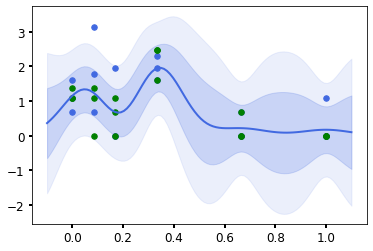

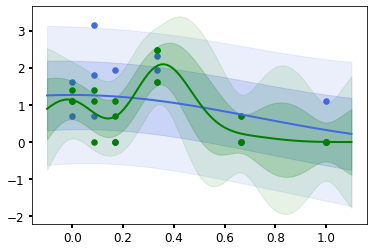

SPBTRNAARG.07


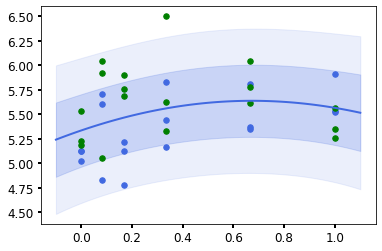

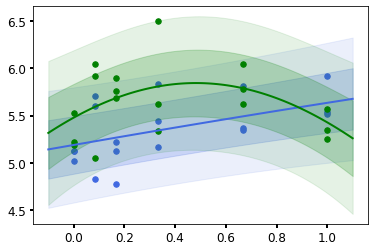

SPNCRNA.735


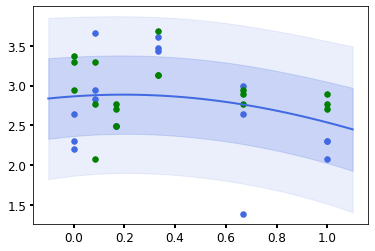

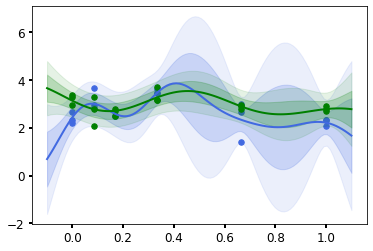

SPBPB2B2.06c


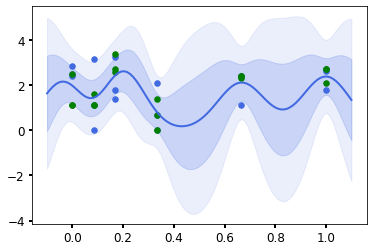

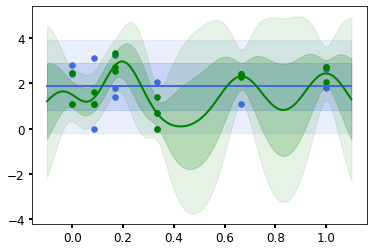

SPAC869.06c


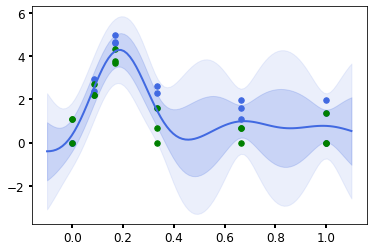

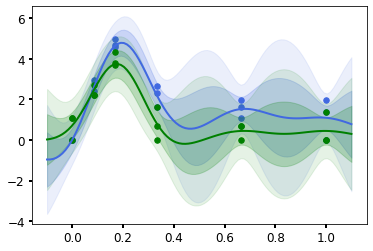

SPCC1281.04


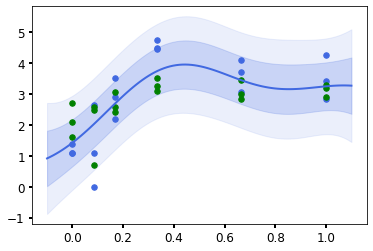

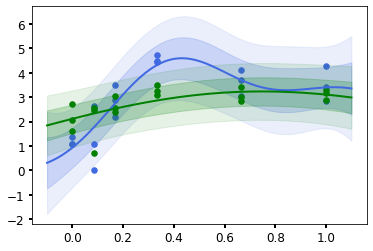

SPBC1711.14


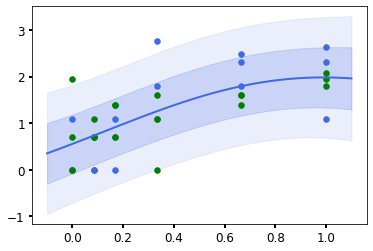

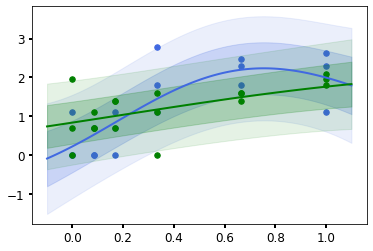

SPAC11D3.01c


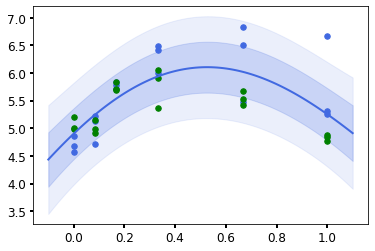

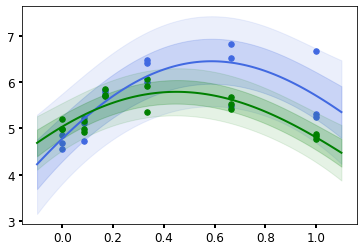

In [7]:
params = gp_counts.load_models(indexes,test,xtest,likelihood)

for i in range(len(indexes)):
    fig = plt.figure()
    print(indexes[i])
    model_index = 1
    for model,mean,var in zip(params['models'][i],params['means'][i],params['vars'][i]):
        plot()
        model_index = model_index + 1

In [ ]:
from GPcounts.GPcounts_Module import Fit_GPcounts
likelihood = 'Gaussian' 
gp_counts = Fit_GPcounts(X.iloc[0:18,:],Y.iloc[[13]])
log_likelihood_ratio = gp_counts.One_sample_test(likelihood)
log_likelihood_ratio

In [ ]:
indexes = log_likelihood_ratio.index.values # list of genes to be plotted 
test = 'One_samples_test' # name of the test
xtest = np.linspace(np.min(X.values)-.1,np.max(X.values)+.1,100)[:,None] # points to make prediction

params = gp_counts.load_models(indexes,test,xtest,likelihood)

for i in range(len(indexes)):
    fig = plt.figure()
    print(indexes[i])
    model_index = 1
    for model,mean,var in zip(params['models'][i],params['means'][i],params['vars'][i]):
        plot()
        model_index = model_index + 1